# **Importing Modules and Libraries**

In [ ]:
%pip install transformers scikit-learn matplotlib pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import re


In [14]:
import os
#os.environ['AMD_SERIALIZE_KERNEL'] ='3'
#os.environ['TORCH_USE_HIP_DSA'] ='1'
#os.environ['HIP_VISIBLE_DEVICES']='0'
#os.environ['PYTORCH_ROCM_ARCH'] = '"gfx1031"'
os.environ['HSA_OVERRIDE_GFX_VERSION'] ='10.3.0'

import torch

# Checking if ROCm is available
if torch.backends.mps.is_available():
    print("ROCm backend is available")

# This will list the ROCm-supported devices
if torch.cuda.is_available():
    print(f"Available AMD GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No ROCm-compatible GPU detected")

Available AMD GPU: Tesla T4


# **Importing Datasets**

In [15]:
import requests
import zipfile

file_name = 'obfuscated-malware-memory-2022-cic.zip' # Changed to .zip to reflect download
csv_file_name = 'Obfuscated-MalMem2022.csv'
download_url = 'https://www.kaggle.com/api/v1/datasets/download/luccagodoy/obfuscated-malware-memory-2022-cic'

# Check if the CSV file already exists
if not os.path.exists(csv_file_name):
    # Check if the zip file exists
    if not os.path.exists(file_name):
        print(f"{file_name} does not exist. Downloading now...")
        headers = {'User-Agent': 'Mozilla/5.0'} # Kaggle might require User-Agent
        response = requests.get(download_url, headers=headers, stream=True)
        response.raise_for_status() # Raise an exception for bad status codes

        with open(file_name, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print("Download complete.")
    else:
        print(f"{file_name} already exists. Skipping download.")

    # Unzip the file if the CSV does not exist
    print("Unzipping the file...")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall('.') # Extract to the current directory
    print("Unzipping complete.")
else:
    print(f"{csv_file_name} already exists. Skipping download and unzip.")

obfuscated-malware-memory-2022-cic.zip does not exist. Downloading now...
Download complete.
Unzipping the file...
Unzipping complete.


In [16]:
data = pd.read_csv('Obfuscated-MalMem2022.csv')


#**Data Cleaning**

In [ ]:
data.head(n=5)


,Category,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,...,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Class
0,Benign,45,17,10.555556,0,202.844444,1694,38.500000,9129,212.302326,...,221,26,24,116,0,121,87,0,8,Benign
1,Benign,47,19,11.531915,0,242.234043,2074,44.127660,11385,242.234043,...,222,26,24,118,0,122,87,0,8,Benign
2,Benign,40,14,14.725000,0,288.225000,1932,48.300000,11529,288.225000,...,222,26,27,118,0,120,88,0,8,Benign
3,Benign,32,13,13.500000,0,264.281250,1445,45.156250,8457,264.281250,...,222,26,27,118,0,120,88,0,8,Benign
4,Benign,42,16,11.452381,0,281.333333,2067,49.214286,11816,281.333333,...,222,26,24,118,0,124,87,0,8,Benign


In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58596 entries, 0 to 58595
Data columns (total 57 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Category                                58596 non-null  object 
 1   pslist.nproc                            58596 non-null  int64  
 2   pslist.nppid                            58596 non-null  int64  
 3   pslist.avg_threads                      58596 non-null  float64
 4   pslist.nprocs64bit                      58596 non-null  int64  
 5   pslist.avg_handlers                     58596 non-null  float64
 6   dlllist.ndlls                           58596 non-null  int64  
 7   dlllist.avg_dlls_per_proc               58596 non-null  float64
 8   handles.nhandles                        58596 non-null  int64  
 9   handles.avg_handles_per_proc            58596 non-null  float64
 10  handles.nport                           58596 non-null  in

##Mengatasi missing value

In [17]:
data.isnull().sum()


,0
Category,0
pslist.nproc,0
pslist.nppid,0
pslist.avg_threads,0
pslist.nprocs64bit,0
pslist.avg_handlers,0
dlllist.ndlls,0
dlllist.avg_dlls_per_proc,0
handles.nhandles,0
handles.avg_handles_per_proc,0


In [18]:
data.shape

(58596, 57)

In [19]:
data.dropna(inplace=True)

In [20]:
data.shape

(58596, 57)

##Memeriksa distribusi kategori

In [ ]:
data['Category'].value_counts()

Category
Benign                                                                                    29298
Ransomware-Pysa-5f3166fc81e2415abe55db02124934be66e02c8ac573bd3f3a0a6d8b73a7a7fc-3.raw        2
Ransomware-Pysa-5f3166fc81e2415abe55db02124934be66e02c8ac573bd3f3a0a6d8b73a7a7fc-5.raw        2
Ransomware-Pysa-5f3166fc81e2415abe55db02124934be66e02c8ac573bd3f3a0a6d8b73a7a7fc-6.raw        2
Ransomware-Pysa-5f3166fc81e2415abe55db02124934be66e02c8ac573bd3f3a0a6d8b73a7a7fc-7.raw        2
                                                                                          ...  
Ransomware-Ako-0a1e176eded8c1801fcd09e8cf9f796c326bc7e9b51531fb40a32f5214d6ba76-2.raw         1
Ransomware-Ako-0a1e176eded8c1801fcd09e8cf9f796c326bc7e9b51531fb40a32f5214d6ba76-3.raw         1
Ransomware-Ako-0a1e176eded8c1801fcd09e8cf9f796c326bc7e9b51531fb40a32f5214d6ba76-4.raw         1
Ransomware-Ako-0a1e176eded8c1801fcd09e8cf9f796c326bc7e9b51531fb40a32f5214d6ba76-5.raw         1
Ransomware-Ako-00a2c6bab1e53f67

##Merubah Kategori

Dua kolom ditambahkan seperti *Sub_Category* dan *Main_Category* agar bisa diperjelas

In [21]:
def extract_category(value):
    match = re.match(r'^[^-]+-[^-]+', value)
    if match:
        return match.group()
    return value

In [22]:
data['Cleaned_Category'] = data['Category'].apply(extract_category)

In [23]:
data['Cleaned_Category'].value_counts()

,count
Cleaned_Category,
Benign,29298
Spyware-Transponder,2410
Spyware-Gator,2200
Ransomware-Shade,2128
Spyware-CWS,2000
Trojan-Scar,2000
Spyware-180solutions,2000
Ransomware-Ako,2000
Trojan-Refroso,2000


In [24]:
data['Main_Category'] = data['Cleaned_Category'].apply(lambda x: x.split('-')[0])

In [25]:
data['Main_Category'].value_counts()

,count
Main_Category,
Benign,29298
Spyware,10020
Ransomware,9791
Trojan,9487


In [26]:
data = data[~data['Main_Category'].isin(['Spyware', 'Trojan'])]
data['Main_Category'].value_counts()

,count
Main_Category,
Benign,29298
Ransomware,9791


In [27]:
data['Sub_Category'] = data['Cleaned_Category'].apply(lambda x: x.split('-')[1] if '-' in x else x)

In [28]:
data['Sub_Category'].value_counts()

,count
Sub_Category,
Benign,29298
Shade,2128
Ako,2000
Conti,1988
Maze,1958
Pysa,1717


In [29]:
data.drop(columns="Category",inplace=True)
data.drop(columns="Class", inplace=True)
data.drop(columns="Cleaned_Category",inplace=True)
data.drop(columns="Main_Category",inplace=True)

In [30]:
data.to_csv('data.csv')

##**Merubah data menjadi numerik**

In [31]:
# Identifying different types of columns
nominal_names = data.select_dtypes(include=['object']).columns
integer_names = data.select_dtypes(include=['int', 'int64']).columns
binary_names = []
float_names = data.select_dtypes(include=['float', 'float64']).columns

In [32]:
# Identifying binary columns (with only two unique values, e.g., 0 and 1)
for c in data.columns:
    if data[c].nunique() == 2 and data[c].dtype in ['int64', 'int', 'float64']:
        binary_names.append(c)

# Converting integer columns to numeric
for c in integer_names:
    data[c] = pd.to_numeric(data[c])

# Converting binary columns to numeric (optional step if already int/float)
for c in binary_names:
    data[c] = pd.to_numeric(data[c])

# Converting float columns to numeric
for c in float_names:
    data[c] = pd.to_numeric(data[c])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39089 entries, 0 to 58595
Data columns (total 56 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   pslist.nproc                            39089 non-null  int64  
 1   pslist.nppid                            39089 non-null  int64  
 2   pslist.avg_threads                      39089 non-null  float64
 3   pslist.nprocs64bit                      39089 non-null  int64  
 4   pslist.avg_handlers                     39089 non-null  float64
 5   dlllist.ndlls                           39089 non-null  int64  
 6   dlllist.avg_dlls_per_proc               39089 non-null  float64
 7   handles.nhandles                        39089 non-null  int64  
 8   handles.avg_handles_per_proc            39089 non-null  float64
 9   handles.nport                           39089 non-null  int64  
 10  handles.nfile                           39089 non-null  int64  

# **Data Visualization**

##**Sub-Class Visualization**

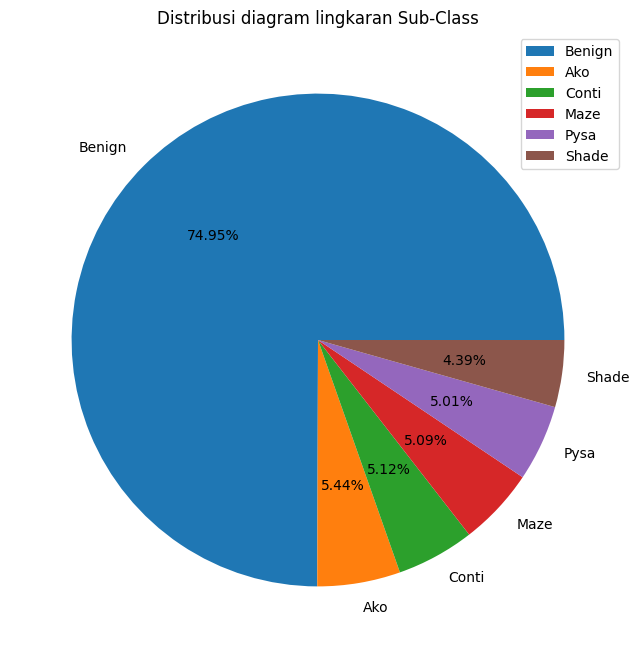

In [ ]:
plt.figure(figsize=(8,8))
plt.pie(data.Sub_Category.value_counts(),labels=data.Sub_Category.unique(),autopct='%0.2f%%')
plt.title('Distribusi diagram lingkaran Sub-Class')
plt.legend(loc='best')
plt.show()

#**Label Encoding**

In [33]:
bin_label = pd.DataFrame(data.Sub_Category)

In [34]:
bin_data = data.copy()

In [35]:
le1 = preprocessing.LabelEncoder()
enc_label = bin_label.apply(le1.fit_transform)
bin_data['Sub_Category'] = enc_label

In [36]:
le1.classes_

array(['Ako', 'Benign', 'Conti', 'Maze', 'Pysa', 'Shade'], dtype=object)

In [37]:
np.save("le1_classes.npy",le1.classes_,allow_pickle=True)

# **Correlation between features of dataset**

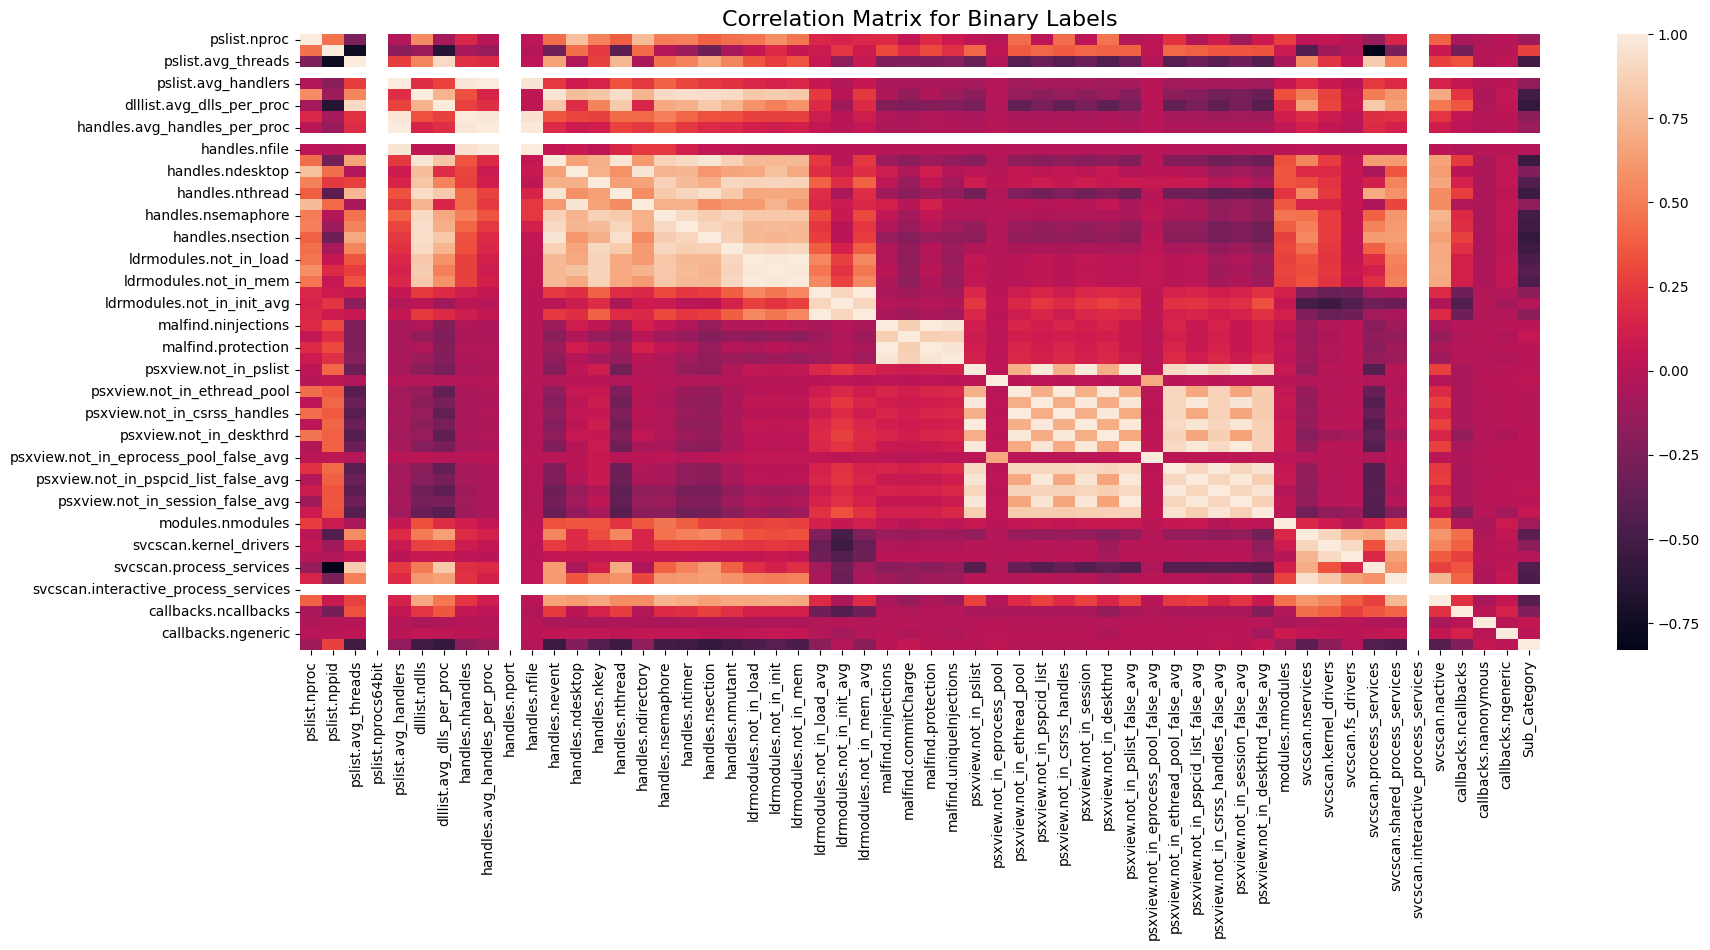

In [39]:
plt.figure(figsize=(20,8))
corr_bin = bin_data.corr()
sns.heatmap(corr_bin,vmax=1.0,annot=False)
plt.title('Correlation Matrix for Binary Labels',fontsize=16)
plt.show()

# **Feature Selection**

In [40]:
corr_ybin = abs(corr_bin['Sub_Category'])
highest_corr_bin = corr_ybin[corr_ybin >= 0.20]
highest_corr_bin.sort_values(ascending=True)

,Sub_Category
handles.ndesktop,0.221005
callbacks.ncallbacks,0.228917
pslist.nppid,0.274871
svcscan.nservices,0.389798
ldrmodules.not_in_init,0.414736
svcscan.nactive,0.418488
handles.nkey,0.438590
svcscan.process_services,0.440829
svcscan.shared_process_services,0.459790
ldrmodules.not_in_mem,0.461366


In [41]:
bin_cols = highest_corr_bin.index
bin_cols

Index(['pslist.nppid', 'pslist.avg_threads', 'dlllist.ndlls',
       'dlllist.avg_dlls_per_proc', 'handles.nevent', 'handles.ndesktop',
       'handles.nkey', 'handles.nthread', 'handles.nsemaphore',
       'handles.ntimer', 'handles.nsection', 'handles.nmutant',
       'ldrmodules.not_in_load', 'ldrmodules.not_in_init',
       'ldrmodules.not_in_mem', 'svcscan.nservices',
       'svcscan.process_services', 'svcscan.shared_process_services',
       'svcscan.nactive', 'callbacks.ncallbacks', 'Sub_Category'],
      dtype='object')

In [42]:
bin_data = bin_data[bin_cols].copy()
bin_data

,pslist.nppid,pslist.avg_threads,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nevent,handles.ndesktop,handles.nkey,handles.nthread,handles.nsemaphore,handles.ntimer,...,handles.nmutant,ldrmodules.not_in_load,ldrmodules.not_in_init,ldrmodules.not_in_mem,svcscan.nservices,svcscan.process_services,svcscan.shared_process_services,svcscan.nactive,callbacks.ncallbacks,Sub_Category
0,17,10.555556,1694,38.500000,3161,46,716,887,671,125,...,257,53,95,53,389,24,116,121,87,1
1,19,11.531915,2074,44.127660,3761,51,1011,1030,766,148,...,394,77,123,77,392,24,118,122,87,1
2,14,14.725000,1932,48.300000,3996,45,784,1241,645,138,...,338,51,89,51,395,27,118,120,88,1
3,13,13.500000,1445,45.156250,2961,36,654,792,567,127,...,242,31,62,31,395,27,118,120,88,1
4,16,11.452381,2067,49.214286,3834,45,1252,942,825,135,...,429,102,143,102,392,24,118,124,87,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58591,15,10.108108,1453,39.270270,2819,40,668,664,596,113,...,230,43,79,43,389,24,116,120,86,5
58592,14,9.945946,1347,36.405405,2394,39,555,624,482,102,...,203,43,79,43,389,24,116,116,88,5
58593,15,9.842105,1448,38.105263,2816,40,673,661,596,113,...,230,43,79,43,389,24,116,120,88,5
58594,15,10.243243,1452,39.243243,2819,40,668,667,596,113,...,230,43,79,43,389,24,116,120,87,5


In [ ]:
#value_map = {
#    0: 'Benign',
#    1: 'Ransomware',
#    2: 'Spyware',
#    3: 'Trojan'
#}

#bin_data['Main_Category'] = bin_data['Main_Category'].map(value_map)

In [ ]:
bin_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39089 entries, 0 to 58595
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   pslist.nppid                     39089 non-null  int64  
 1   pslist.avg_threads               39089 non-null  float64
 2   dlllist.ndlls                    39089 non-null  int64  
 3   dlllist.avg_dlls_per_proc        39089 non-null  float64
 4   handles.nevent                   39089 non-null  int64  
 5   handles.ndesktop                 39089 non-null  int64  
 6   handles.nkey                     39089 non-null  int64  
 7   handles.nthread                  39089 non-null  int64  
 8   handles.nsemaphore               39089 non-null  int64  
 9   handles.ntimer                   39089 non-null  int64  
 10  handles.nsection                 39089 non-null  int64  
 11  handles.nmutant                  39089 non-null  int64  
 12  ldrmodules.not_in_load 

# **Data Normalization**


In [43]:
X_n = bin_data.drop(columns=['Sub_Category'])
y_n = bin_data['Sub_Category']

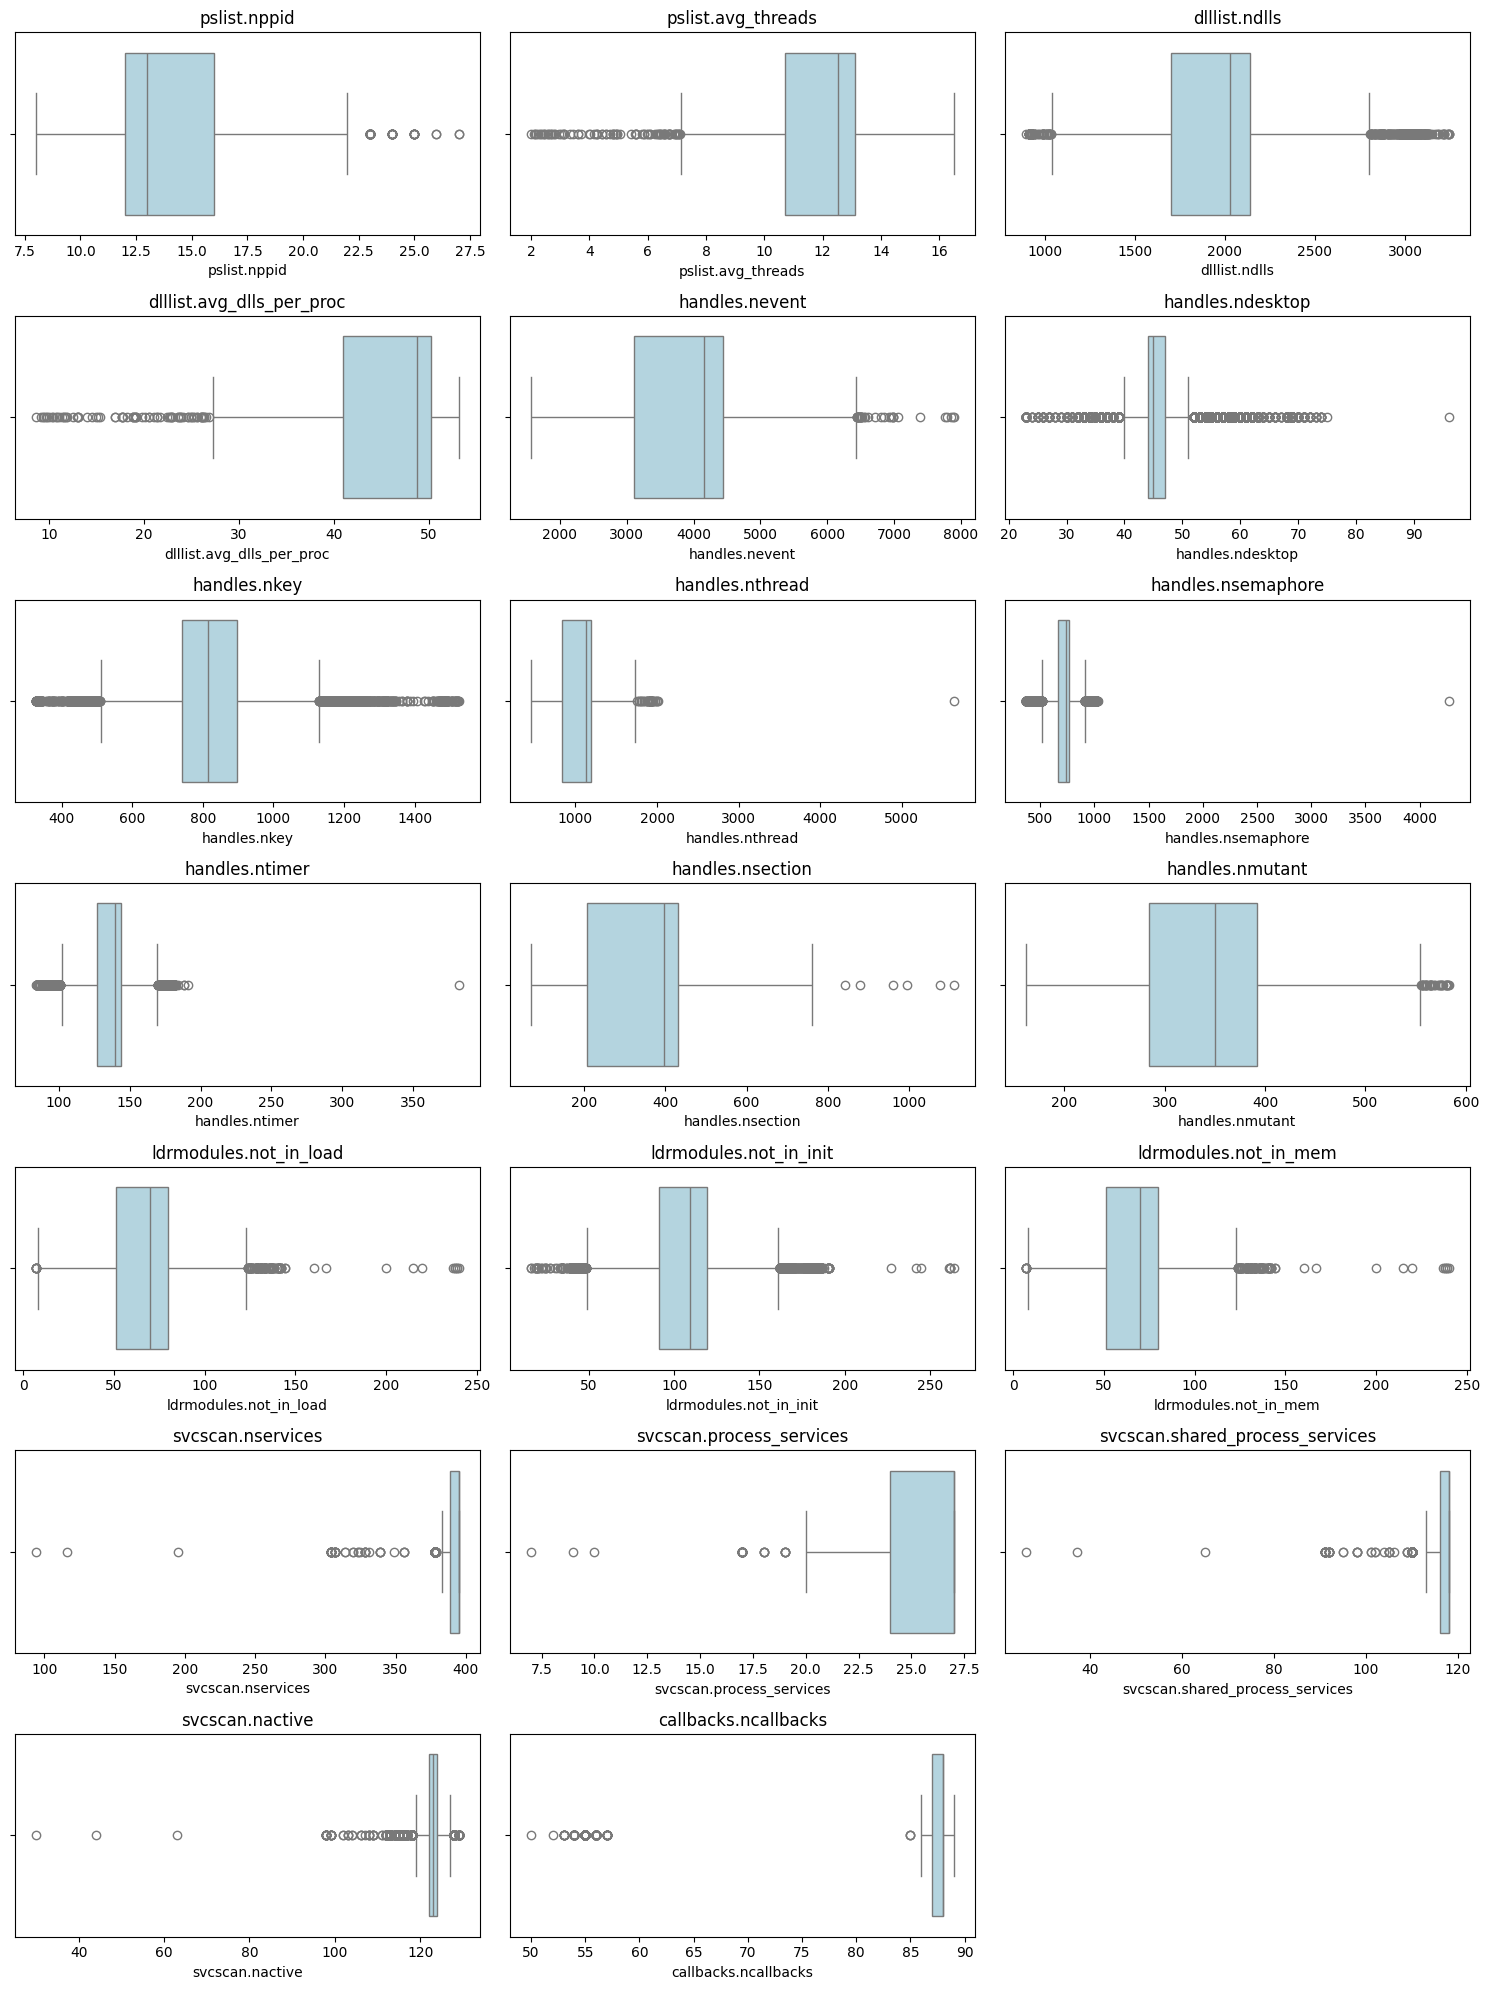

In [44]:
# Using boxplots to check for outliers in each feature
plt.figure(figsize=(15, 20))
num_features = X_n.columns

# Creating subplots for each feature to visualize outliers
for i, feature in enumerate(num_features):
    plt.subplot(7, 3, i + 1)  # Creating subplots in a grid of 7 rows and 3 columns
    sns.boxplot(x=X_n[feature], color='lightblue')
    plt.title(feature)
    plt.tight_layout()

plt.show()

In [45]:
import numpy as np

# Calculate the first and third quartiles
Q1 = np.percentile(X_n, 25, axis=0)
Q3 = np.percentile(X_n, 75, axis=0)
IQR = Q3 - Q1

# Define the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a mask to filter out rows where all features are within the bounds
non_outlier_mask = ((X_n >= lower_bound) & (X_n <= upper_bound)).all(axis=1)

# Filter the dataset
X_no_outliers = X_n[non_outlier_mask]

# X_no_outliers = X_n[non_outlier_mask]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_no_outliers)

In [46]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X_n.columns)

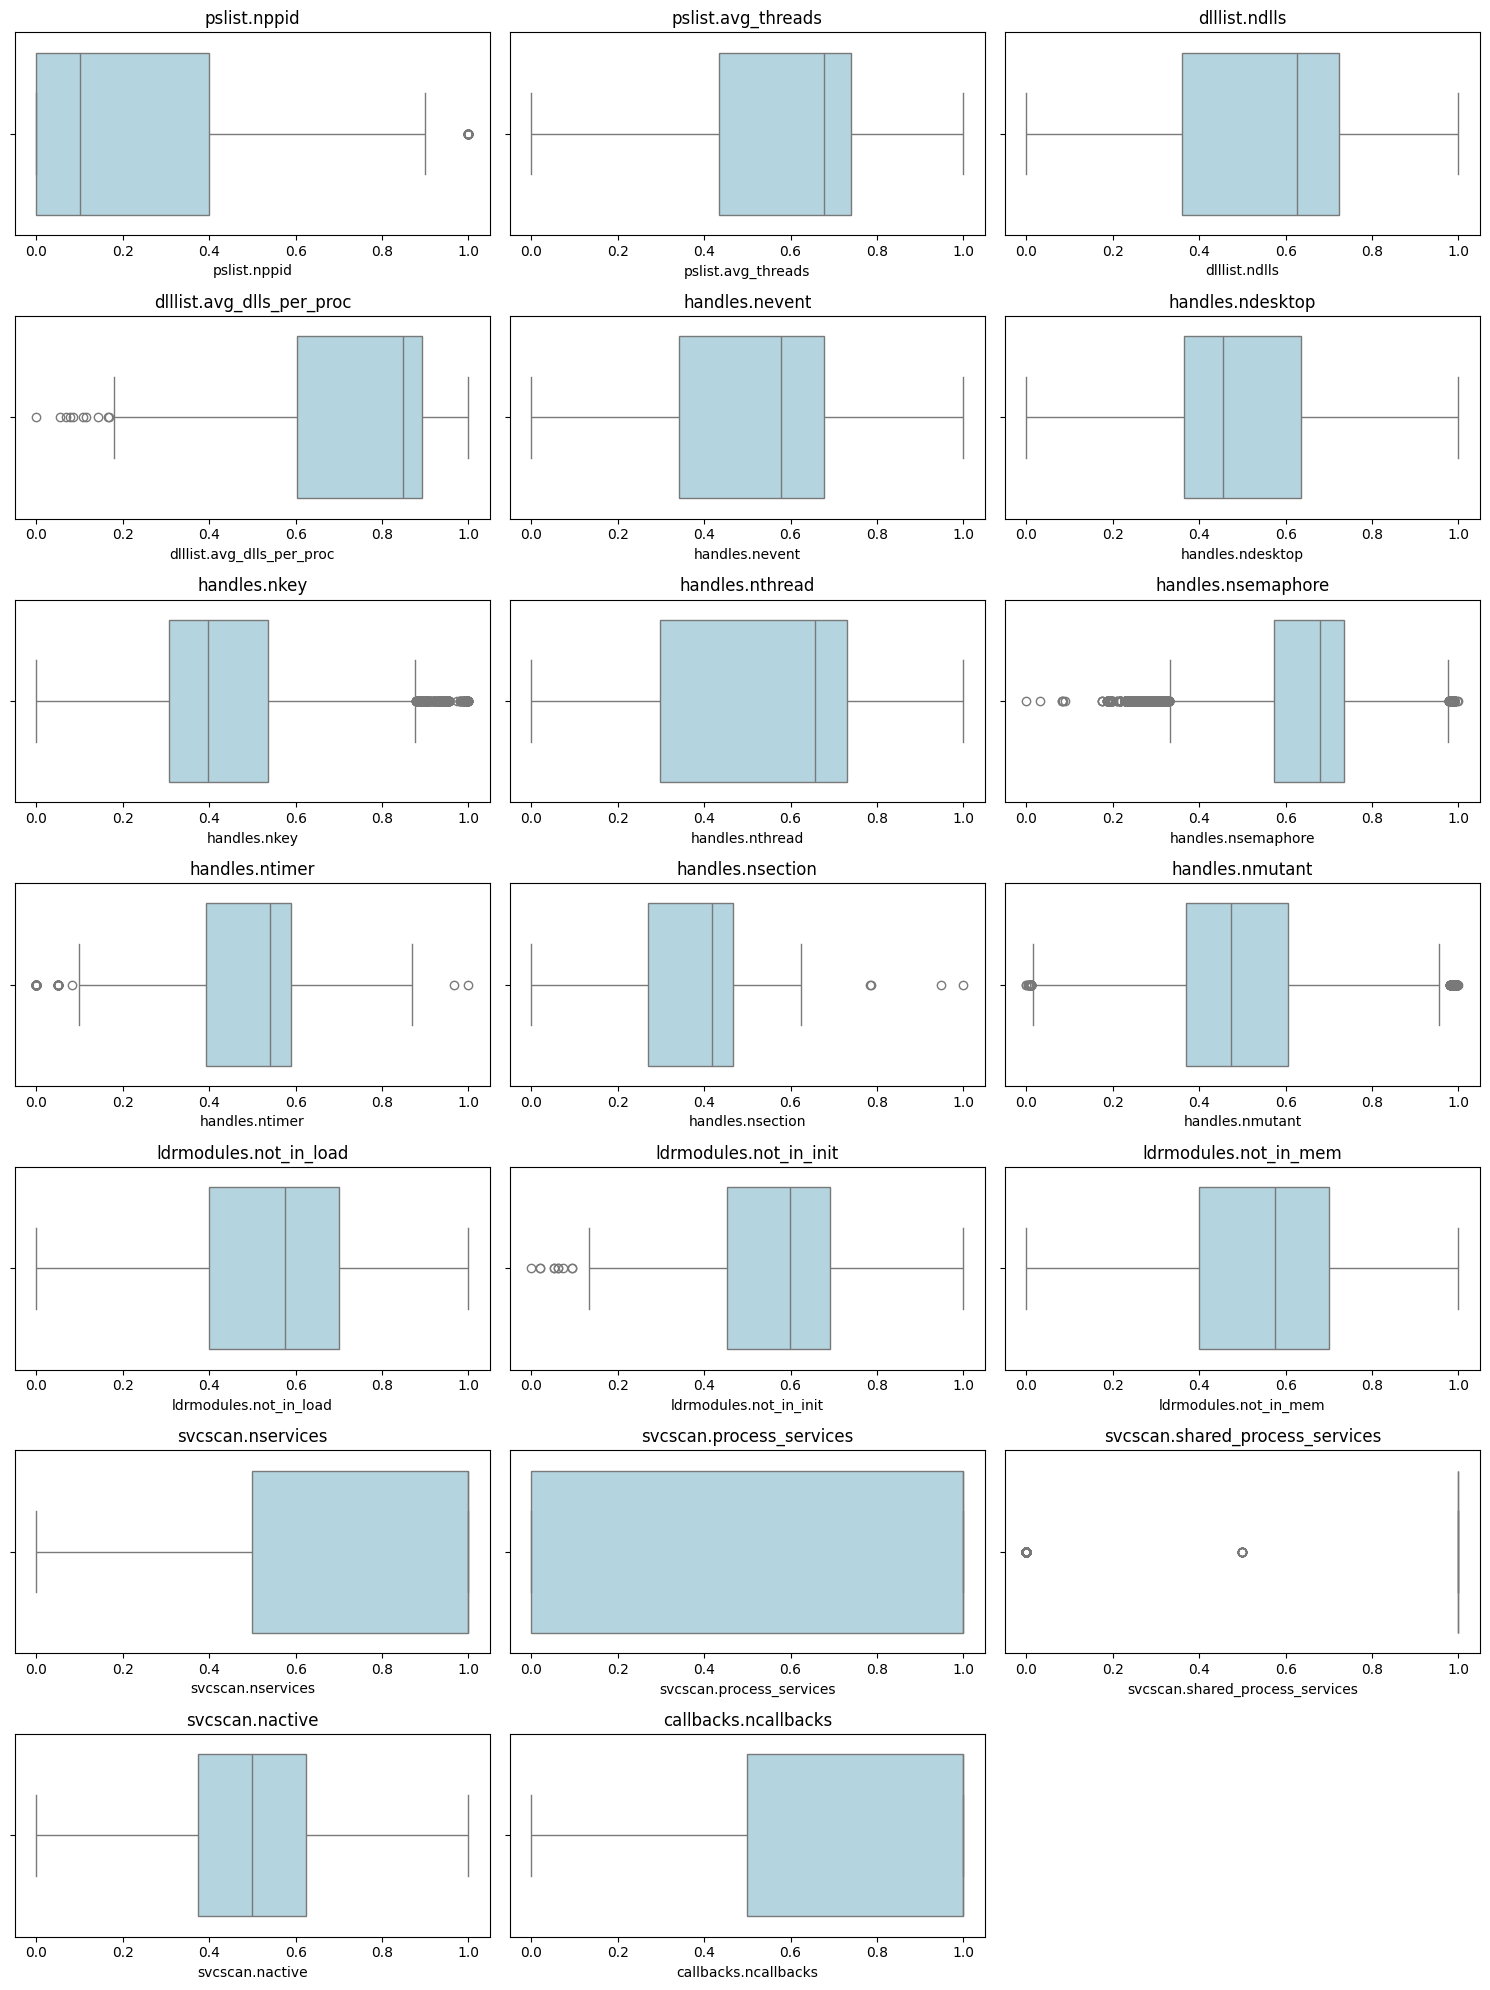

In [47]:
# Using boxplots to check for outliers in each feature
plt.figure(figsize=(15, 20))
num_features_s = X_scaled_df.columns

# Creating subplots for each feature to visualize outliers
for i, feature in enumerate(num_features_s):
    plt.subplot(7, 3, i + 1)  # Creating subplots in a grid of 7 rows and 3 columns
    sns.boxplot(x=X_scaled_df[feature], color='lightblue')
    plt.title(feature)
    plt.tight_layout()

plt.show()

In [48]:
combined_data = pd.concat([X_scaled_df, y_n.reset_index(drop=True)], axis=1)

In [49]:
# Total number of rows in the DataFrame
total_rows = len(combined_data)

# Calculate percentage of null values
null_percentage = (combined_data.isnull().sum() / total_rows) * 100

# Display the percentage of null values for each column
print(null_percentage)

pslist.nppid                       15.324004
pslist.avg_threads                 15.324004
dlllist.ndlls                      15.324004
dlllist.avg_dlls_per_proc          15.324004
handles.nevent                     15.324004
handles.ndesktop                   15.324004
handles.nkey                       15.324004
handles.nthread                    15.324004
handles.nsemaphore                 15.324004
handles.ntimer                     15.324004
handles.nsection                   15.324004
handles.nmutant                    15.324004
ldrmodules.not_in_load             15.324004
ldrmodules.not_in_init             15.324004
ldrmodules.not_in_mem              15.324004
svcscan.nservices                  15.324004
svcscan.process_services           15.324004
svcscan.shared_process_services    15.324004
svcscan.nactive                    15.324004
callbacks.ncallbacks               15.324004
Sub_Category                        0.000000
dtype: float64


In [50]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
combined_data.iloc[:, :] = imputer.fit_transform(combined_data)

In [51]:
# Total number of rows in the DataFrame
total_rows = len(combined_data)

# Calculate percentage of null values
null_percentage = (combined_data.isnull().sum() / total_rows) * 100

# Display the percentage of null values for each column
print(null_percentage)

pslist.nppid                       0.0
pslist.avg_threads                 0.0
dlllist.ndlls                      0.0
dlllist.avg_dlls_per_proc          0.0
handles.nevent                     0.0
handles.ndesktop                   0.0
handles.nkey                       0.0
handles.nthread                    0.0
handles.nsemaphore                 0.0
handles.ntimer                     0.0
handles.nsection                   0.0
handles.nmutant                    0.0
ldrmodules.not_in_load             0.0
ldrmodules.not_in_init             0.0
ldrmodules.not_in_mem              0.0
svcscan.nservices                  0.0
svcscan.process_services           0.0
svcscan.shared_process_services    0.0
svcscan.nactive                    0.0
callbacks.ncallbacks               0.0
Sub_Category                       0.0
dtype: float64


In [52]:
combined_data['Sub_Category'].value_counts()

,count
Sub_Category,
1,29298
5,2128
0,2000
2,1988
3,1958
4,1717


In [53]:
combined_data.to_csv('bin_data_scaled.csv', index=False)

# **Data Balancing**

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

In [55]:
data_bin = pd.read_csv("bin_data_scaled.csv")

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# Assuming data_bin is your DataFrame with features and 'Sub_Category' as the target column
# Separate features (X) and target (y)
X_bin = data_bin.drop(columns=['Sub_Category']).values
y_bin = data_bin['Sub_Category'].values

# Split central and client data, ensuring stratification of classes
X_central, X_clients, y_central, y_clients = train_test_split(X_bin, y_bin, test_size=0.7, random_state=55, stratify=y_bin)

# Shuffle the indices
indices = np.arange(len(X_clients))
np.random.shuffle(indices)

# Split the shuffled indices into 3 clients
client_splits = np.array_split(indices, 3)

# Create client data based on the new splits
client_data = [(X_clients[split_indices], y_clients[split_indices]) for split_indices in client_splits]

# Export client data to CSV files with the correct feature names
feature_columns = data_bin.drop(columns=['Sub_Category']).columns

for i, (X_client, y_client) in enumerate(client_data, start=1):
    df_client = pd.DataFrame(X_client, columns=feature_columns)  # Use actual feature names
    df_client['Sub_Category'] = y_client
    df_client.to_csv(f"client_data_{i}.csv", index=False)

In [ ]:
# Visualize the distribution before SMOTE
def visualize_distribution(y_data, title):
    counter = Counter(y_data)
    print(counter.keys(),counter.values())
    plt.bar(counter.keys(), counter.values())
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
# Apply SMOTE to each client and visualize the distribution after SMOTE
smote = SMOTE(random_state=120)

dict_keys([np.int64(1), np.int64(2), np.int64(5), np.int64(0), np.int64(3), np.int64(4)]) dict_values([8789, 596, 638, 600, 588, 515])


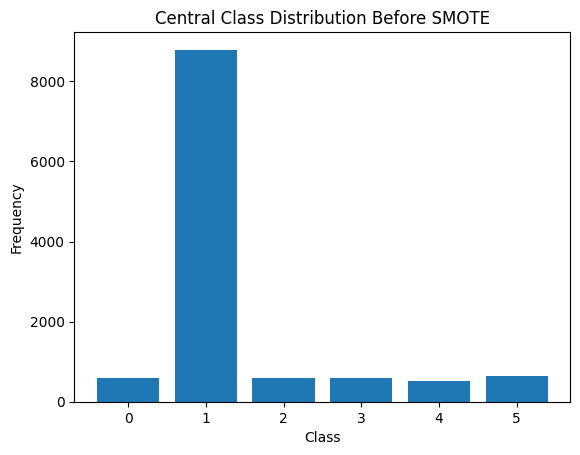

In [ ]:
# Visualize distribution for central data before SMOTE
visualize_distribution(y_central, title='Central Class Distribution Before SMOTE')

dict_keys([np.int64(1), np.int64(2), np.int64(5), np.int64(0), np.int64(3), np.int64(4)]) dict_values([8789, 8789, 8789, 8789, 8789, 8789])


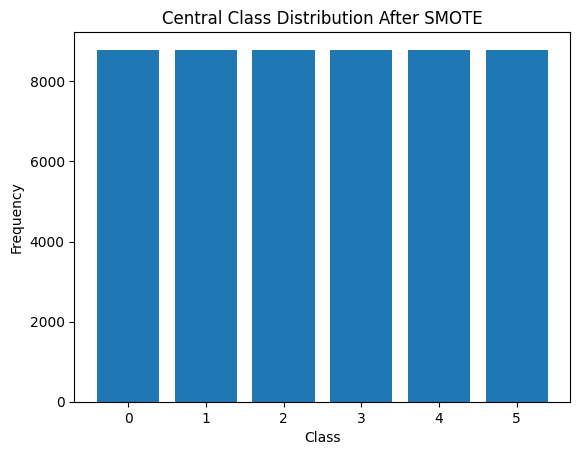

In [ ]:
# Apply SMOTE to central data and visualize the distribution after SMOTE
X_central_resampled, y_central_resampled = smote.fit_resample(X_central, y_central)
visualize_distribution(y_central_resampled, title='Central Class Distribution After SMOTE')

dict_keys([np.int64(1), np.int64(5), np.int64(4), np.int64(3), np.int64(2), np.int64(0)]) dict_values([6874, 494, 382, 445, 474, 452])


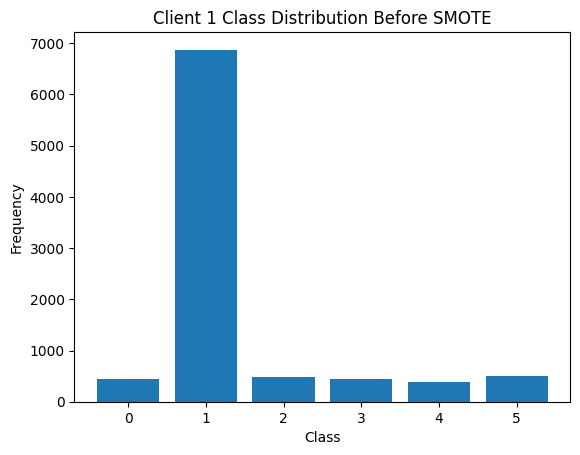

dict_keys([np.int64(1), np.int64(4), np.int64(0), np.int64(3), np.int64(2), np.int64(5)]) dict_values([6847, 413, 468, 461, 431, 501])


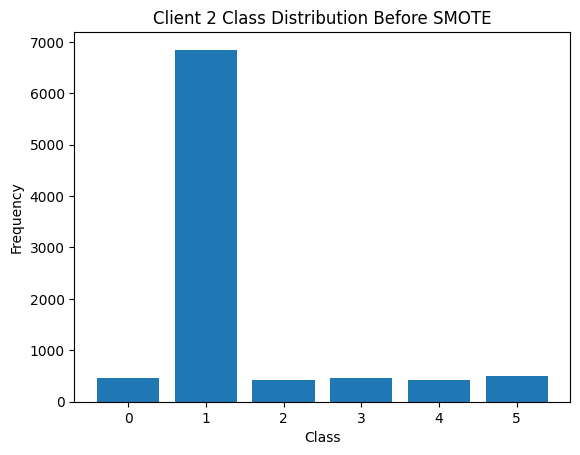

dict_keys([np.int64(5), np.int64(1), np.int64(0), np.int64(4), np.int64(2), np.int64(3)]) dict_values([495, 6788, 480, 407, 487, 464])


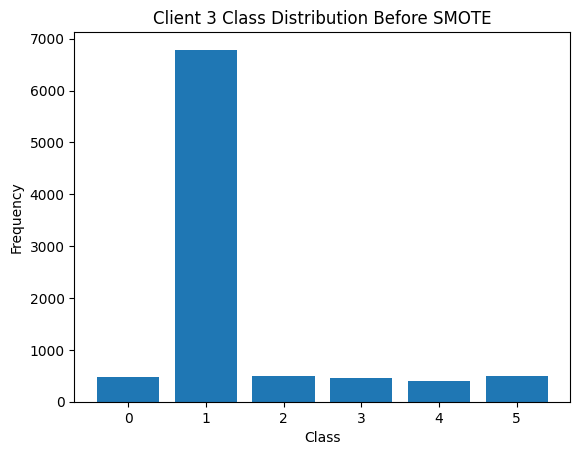

In [ ]:
# Visualize distribution for each client before SMOTE
for i, (X_client, y_client) in enumerate(client_data):
    visualize_distribution(y_client, title=f'Client {i+1} Class Distribution Before SMOTE')

dict_keys([np.int64(1), np.int64(5), np.int64(4), np.int64(3), np.int64(2), np.int64(0)]) dict_values([6874, 6874, 6874, 6874, 6874, 6874])


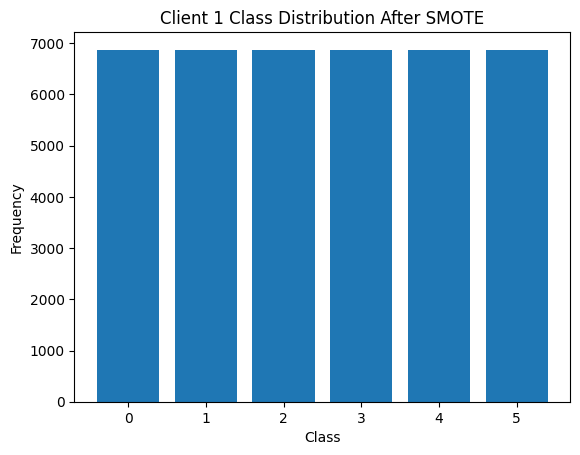

dict_keys([np.int64(1), np.int64(4), np.int64(0), np.int64(3), np.int64(2), np.int64(5)]) dict_values([6847, 6847, 6847, 6847, 6847, 6847])


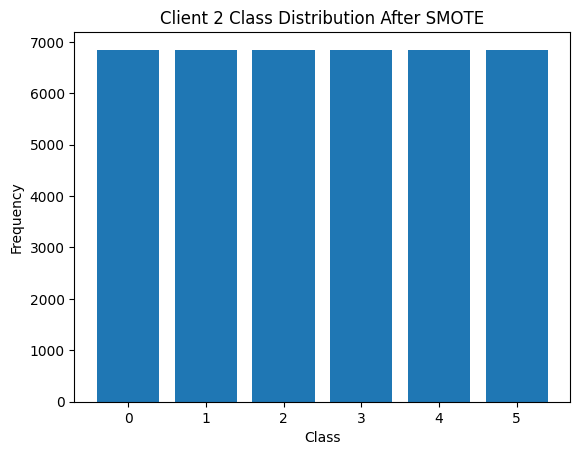

dict_keys([np.int64(5), np.int64(1), np.int64(0), np.int64(4), np.int64(2), np.int64(3)]) dict_values([6788, 6788, 6788, 6788, 6788, 6788])


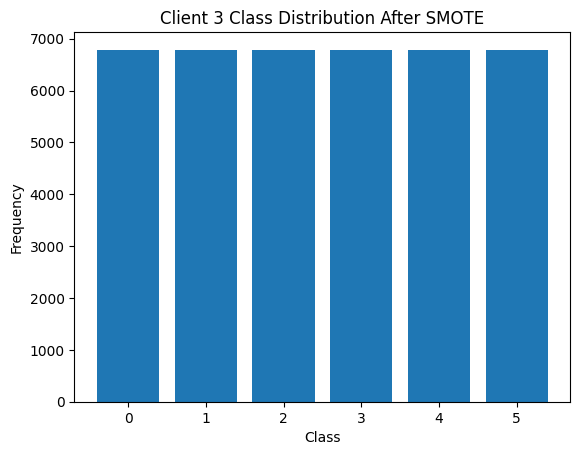

In [ ]:
client_data_smoted = []
for i, (X_client, y_client) in enumerate(client_data):
    X_client_resampled, y_client_resampled = smote.fit_resample(X_client, y_client)
    client_data_smoted.append((X_client_resampled, y_client_resampled))
    visualize_distribution(y_client_resampled, title=f'Client {i+1} Class Distribution After SMOTE')

# Further split client data into 5 clients
client_splits_smoted = np.array_split(np.arange(len(X_client_resampled)), 3)

# **Training**

**NOTE** \\
Penggunaan Variable untuk Balance dan Imbalance sebagai berikut:
- X_central: Imbalance (untuk Central sebelum SMOTE)
- X_clients: Imbalance (untuk Client sebelum SMOTE)
- X_central_resampled: Balanced (untuk Central setelah SMOTE)
- X_client_resampled: Balanced (untuk masing-masing Client setelah SMOTE)
- y_central: Imbalance (untuk Central sebelum SMOTE)
- y_clients: Imbalance (untuk Client sebelum SMOTE)
- y_central_resampled: Balanced (untuk Central setelah SMOTE)
- y_client_resampled: Balanced (untuk masing-masing Client setelah SMOTE)

In [ ]:
unique_values = np.unique(y_central)
print(unique_values)

[0 1 2 3 4 5]


In [ ]:
folder_name = 'Imbalanced'

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"{folder_name} already exists. Skipping Folder Creation.")

Imbalanced already exists. Skipping Folder Creation.


In [60]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
)
from torch.utils.data import DataLoader, Subset, TensorDataset, random_split
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import warnings
from torch.optim.lr_scheduler import ReduceLROnPlateau# Import necessary library
from sklearn.model_selection import train_test_split
import itertools

In [ ]:
central_dataset = TensorDataset(
    torch.tensor(X_central, dtype=torch.float32), torch.tensor(y_central, dtype=torch.long)
)
client_datasets = [
    TensorDataset(
        torch.tensor(X_clients[indices], dtype=torch.float32),
        torch.tensor(y_clients[indices], dtype=torch.long),
    )
    for indices in client_splits
]

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("GPU is available and being used" if torch.cuda.is_available() else "Using CPU due to lack of GPU")

Using CPU due to lack of GPU


In [8]:
class ProbSparseSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1, factor=5):
        super(ProbSparseSelfAttention, self).__init__()
        self.n_heads = n_heads
        self.factor = factor
        self.scale = 1 / math.sqrt(d_model // n_heads)
        self.dropout = nn.Dropout(dropout)
        self.qkv_proj = nn.Linear(d_model, d_model * 3)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, L, D = x.size()
        H = self.n_heads
        qkv = (
            self.qkv_proj(x)
            .reshape(B, L, 3, H, D // H)
            .permute(2, 0, 3, 1, 4)
        )  # (3, B, H, L, D_head)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each is (B, H, L, D_head)
        scores = torch.einsum("bhid,bhjd->bhij", q, k) * self.scale  # (B, H, L, L)
        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        out = torch.einsum("bhij,bhjd->bhid", attn, v)  # (B, H, L, D_head)
        out = out.transpose(1, 2).reshape(B, L, D)
        out = self.out_proj(out)
        return out

class InformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1, factor=5):
        super(InformerEncoderLayer, self).__init__()
        self.self_attn = ProbSparseSelfAttention(
            d_model, n_heads, dropout=dropout, factor=factor
        )
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, src):
        # Self-attention
        src2 = self.self_attn(src)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        # Feed-forward network
        src2 = self.ffn(src)
        src = src + self.dropout2(src2)
        src = self.norm2(src)

        return src

class InformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers):
        super(InformerEncoder, self).__init__()
        self.layers = nn.ModuleList([encoder_layer for _ in range(num_layers)])

    def forward(self, src):
        for layer in self.layers:
            src = layer(src)
        return src

class InformerModel(nn.Module):
    def __init__(
        self,
        num_continuous,
        d_model,
        d_ff,
        num_layers,
        n_heads,
        output_dim,
        dropout=0.1,
        factor=5,
    ):
        super(InformerModel, self).__init__()
        self.num_continuous = num_continuous
        self.d_model = d_model
        self.value_embedding = nn.Linear(1, d_model)
        self.position_embedding = nn.Parameter(torch.randn(1, num_continuous, d_model))
        encoder_layer = InformerEncoderLayer(
            d_model, n_heads, d_ff, dropout=dropout, factor=factor
        )
        self.encoder = InformerEncoder(encoder_layer, num_layers)
        self.mlp = nn.Sequential(nn.Linear(num_continuous * d_model, output_dim))

    def forward(self, x_cont):
        # x_cont: (batch_size, num_continuous)
        batch_size = x_cont.size(0)
        x = self.value_embedding(x_cont.unsqueeze(-1))  # (batch_size, num_continuous, d_model)
        x += self.position_embedding[:, : self.num_continuous, :]
        x = self.encoder(x)  # (batch_size, num_continuous, d_model)
        x = x.reshape(batch_size, -1)  # (batch_size, num_continuous * d_model)
        out = self.mlp(x)  # (batch_size, output_dim)
        return out

In [58]:
# Hyperparameters
num_continuous = X_central.shape[1]

dim = 256
depth = 4
heads = 8
attn_dropout = 0.3
ff_dropout = 0.1
mlp_hidden_mults = (4, 2)
mlp_act = nn.GELU()
output_dim = len(np.unique(y_bin))
num_epochs = 10
clients = 3
num_rounds = 3
k_folds = 5
batch_size = 32

In [ ]:
warnings.filterwarnings("ignore")

import pandas as pd  # Import pandas for DataFrame operations
from sklearn.metrics import ConfusionMatrixDisplay
from torch.utils.data import ConcatDataset

# Function to train a local model
def train_local_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, client_id=None, fold=None, round_num=None):
    model.train()
    train_epoch_metrics = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
    val_epoch_metrics = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        all_probs = []
        all_preds = []
        all_labels = []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            # Get probabilities and predictions
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            all_probs.extend(probabilities.detach().cpu().numpy())
            all_preds.extend(predicted.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

        # Calculate training metrics for the epoch
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
        try:
            roc_auc = roc_auc_score(all_labels, np.array(all_probs), multi_class='ovr')
        except ValueError:
            roc_auc = 0

        avg_loss = total_loss / len(train_loader)
        train_epoch_metrics['loss'].append(avg_loss)
        train_epoch_metrics['accuracy'].append(accuracy)
        train_epoch_metrics['precision'].append(precision)
        train_epoch_metrics['recall'].append(recall)
        train_epoch_metrics['f1'].append(f1)
        train_epoch_metrics['roc_auc'].append(roc_auc)

        print(f'Train Epoch {epoch + 1}')
        print(f'Accuracy: {accuracy:.4f}, Loss: {avg_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0
        val_all_probs = []
        val_all_preds = []
        val_all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)

                val_all_probs.extend(probabilities.detach().cpu().numpy())
                val_all_preds.extend(predicted.detach().cpu().numpy())
                val_all_labels.extend(labels.detach().cpu().numpy())

        # Calculate validation metrics for the epoch
        val_accuracy = accuracy_score(val_all_labels, val_all_preds)
        val_precision = precision_score(val_all_labels, val_all_preds, average='weighted', zero_division=0)
        val_recall = recall_score(val_all_labels, val_all_preds, average='weighted', zero_division=0)
        val_f1 = f1_score(val_all_labels, val_all_preds, average='weighted', zero_division=0)
        try:
            val_roc_auc = roc_auc_score(val_all_labels, np.array(val_all_probs), multi_class='ovr')
        except ValueError:
            val_roc_auc = 0

        avg_val_loss = val_loss / len(val_loader)
        val_epoch_metrics['loss'].append(avg_val_loss)
        val_epoch_metrics['accuracy'].append(val_accuracy)
        val_epoch_metrics['precision'].append(val_precision)
        val_epoch_metrics['recall'].append(val_recall)
        val_epoch_metrics['f1'].append(val_f1)
        val_epoch_metrics['roc_auc'].append(val_roc_auc)

        print(f'Validation Epoch {epoch + 1}')
        print(f'Accuracy: {val_accuracy:.4f}, Loss: {avg_val_loss:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-Score: {val_f1:.4f}, ROC-AUC: {val_roc_auc:.4f}')
        scheduler.step(val_accuracy)

    # Prepare a DataFrame with the metrics
    epochs = range(1, num_epochs + 1)
    metrics_df = pd.DataFrame({
        'epoch': epochs,
        'train_loss': train_epoch_metrics['loss'],
        'train_accuracy': train_epoch_metrics['accuracy'],
        'train_precision': train_epoch_metrics['precision'],
        'train_recall': train_epoch_metrics['recall'],
        'train_f1': train_epoch_metrics['f1'],
        'train_roc_auc': train_epoch_metrics['roc_auc'],
        'val_loss': val_epoch_metrics['loss'],
        'val_accuracy': val_epoch_metrics['accuracy'],
        'val_precision': val_epoch_metrics['precision'],
        'val_recall': val_epoch_metrics['recall'],
        'val_f1': val_epoch_metrics['f1'],
        'val_roc_auc': val_epoch_metrics['roc_auc']
    })
    # Save the DataFrame to CSV
    metrics_df.to_csv(f'{folder_name}/client_{client_id}_metrics_fold_{fold}_round_{round_num}.csv', index=False)

    print("All metrics saved into CSV file.")

    return model.state_dict()  # Return model weights after training

# Federated Averaging Function
def federated_avg(global_model, client_models):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.mean(
            torch.stack([client_model[k].float() for client_model in client_models]), dim=0
        )
    global_model.load_state_dict(global_dict)
    return global_model

# Evaluation Function
def evaluate_model(model, data_loader, criterion=None):
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if criterion is not None:
                loss = criterion(outputs, labels)
                total_loss += loss.item()
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            all_probs.extend(probabilities.detach().cpu().numpy())
            all_preds.extend(predicted.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    # Calculate ROC AUC
    try:
        roc_auc = roc_auc_score(all_labels, np.array(all_probs), multi_class='ovr')
    except ValueError:
        roc_auc = 0

    if criterion is not None and len(data_loader) > 0:
        avg_loss = total_loss / len(data_loader)
    else:
        avg_loss = None

    conf_matrix = confusion_matrix(all_labels, all_preds, labels=list(range(output_dim)))
    #conf_matrix = confusion_matrix(all_labels, all_preds)


    return accuracy, f1, precision, recall, roc_auc, conf_matrix, avg_loss

# Initialize tracking lists for global metricsconf_matrix = confusion_matrix(all_labels, all_preds)
global_metrics = {
    'train_loss': [],
    'train_accuracy': [],
    'train_precision': [],
    'train_recall': [],
    'train_f1': [],
    'train_roc_auc': [],
    'val_loss': [],
    'val_accuracy': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': [],
    'val_roc_auc': []
}

# K-Fold Cross Validation setup
kf = KFold(n_splits=k_folds, shuffle=True, random_state=80)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(central_dataset)):
    print(f"\nFold {fold + 1}/{k_folds}")

    # Split the central dataset into train and validation sets for this fold
    train_subset = Subset(central_dataset, train_idx)
    val_subset = Subset(central_dataset, val_idx)

    central_train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    central_val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Split each client dataset into training and validation subsets
    client_train_loaders = []
    client_val_loaders = []
    combined_datasets_clients = []

    for client_id, client_dataset in enumerate(client_datasets):
        dataset_size = len(client_dataset)
        val_size = int(0.2 * dataset_size)
        train_size = dataset_size - val_size
        train_subset_client, val_subset_client = random_split(
            client_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(fold + client_id)
        )
        train_loader_client = DataLoader(train_subset_client, batch_size=batch_size, shuffle=True)
        val_loader_client = DataLoader(val_subset_client, batch_size=batch_size, shuffle=False)
        client_train_loaders.append(train_loader_client)
        client_val_loaders.append(val_loader_client)

        # Create combined dataset for the client
        combined_dataset_client = ConcatDataset([train_subset_client, val_subset_client])
        combined_datasets_clients.append(combined_dataset_client)

    # Reset global model and metrics for each fold
    global_model = InformerModel(
        num_continuous=num_continuous,
        d_model=dim,
        d_ff=dim * 4,
        num_layers=depth,
        n_heads=heads,
        output_dim=output_dim,
        dropout=attn_dropout,
        factor=5,
    ).to(device)
    criterion = nn.CrossEntropyLoss()

    # Clear metrics lists for each fold
    for key in global_metrics.keys():
        global_metrics[key].clear()

    # Federated Learning Rounds
    for round in range(num_rounds):
        print(f"\nRound {round+1}/{num_rounds}")
        client_models = []
        client_metrics = []

        for client_id, (train_loader, val_loader) in enumerate(zip(client_train_loaders, client_val_loaders)):
            print(f"\nTraining on Client {client_id + 1}")
            local_model = InformerModel(
                num_continuous=num_continuous,
                d_model=dim,
                d_ff=dim * 4,
                num_layers=depth,
                n_heads=heads,
                output_dim=output_dim,
                dropout=attn_dropout,
                factor=5,
            ).to(device)
            local_model.load_state_dict(global_model.state_dict())  # Start from global model
            optimizer = optim.AdamW(local_model.parameters(), lr=1e-4)
            scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2)
            # Train local model
            print(f"Client {client_id + 1}: Starting training with {len(train_loader)} batches...")
            client_model_weights = train_local_model(
                local_model, train_loader, val_loader, criterion, optimizer, num_epochs, client_id=client_id + 1, fold=fold + 1, round_num=round + 1
            )
            print(f"Client {client_id + 1}: Finished training. Returning model weights.")

            # Create combined loader for the client
            combined_loader = DataLoader(combined_datasets_clients[client_id], batch_size=batch_size, shuffle=False)

            # Evaluate client model on combined training and validation data
            val_accuracy, val_f1, val_precision, val_recall, val_roc_auc, conf_matrix, val_loss = evaluate_model(
                local_model, combined_loader, criterion
            )
            client_metrics.append(
                {
                    "accuracy": val_accuracy,
                    "precision": val_precision,
                    "recall": val_recall,
                    "f1": val_f1,
                    "roc_auc": val_roc_auc,
                    "loss": val_loss
                }
            )

            # Print confusion matrix
            print(f"Client {client_id + 1} Combined Training and Validation Confusion Matrix:")
            print(conf_matrix)

            # Plot and save confusion matrix with round indicator
            classes = [str(i) for i in range(output_dim)]
            disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
            disp.plot(cmap=plt.cm.Blues)
            plt.title(f'Client {client_id + 1} Confusion Matrix on Combined Data (Fold {fold + 1}, Round {round + 1})')
            plt.savefig(f'{folder_name}/client_{client_id + 1}_confusion_matrix_combined_fold_{fold + 1}_round_{round + 1}.png')
            plt.close()

            client_models.append(client_model_weights)

        # Calculate average client metrics
        avg_client_accuracy = np.mean([metric["accuracy"] for metric in client_metrics])
        avg_client_precision = np.mean([metric["precision"] for metric in client_metrics])
        avg_client_recall = np.mean([metric["recall"] for metric in client_metrics])
        avg_client_f1 = np.mean([metric["f1"] for metric in client_metrics])
        avg_client_roc_auc = np.mean([metric["roc_auc"] for metric in client_metrics])

        # Perform Federated Averaging
        print("Performing Federated Averaging to update the global model...")
        global_model = federated_avg(global_model, client_models)
        print("Global model updated.")

        # Create combined dataset and loader for all clients
        combined_clients_dataset = ConcatDataset(combined_datasets_clients)
        combined_clients_loader = DataLoader(combined_clients_dataset, batch_size=batch_size, shuffle=False)

        # Evaluate the global model on the combined client data (train data)
        train_accuracy, train_f1, train_precision, train_recall, train_roc_auc, train_conf_matrix, train_loss = evaluate_model(
            global_model, combined_clients_loader, criterion
        )
        global_metrics['train_loss'].append(train_loss)
        global_metrics['train_accuracy'].append(train_accuracy)
        global_metrics['train_precision'].append(train_precision)
        global_metrics['train_recall'].append(train_recall)
        global_metrics['train_f1'].append(train_f1)
        global_metrics['train_roc_auc'].append(train_roc_auc)

        # Evaluate the global model on the central validation set
        val_accuracy, val_f1, val_precision, val_recall, val_roc_auc, val_conf_matrix, val_loss = evaluate_model(
            global_model, central_val_loader, criterion
        )
        global_metrics['val_loss'].append(val_loss)
        global_metrics['val_accuracy'].append(val_accuracy)
        global_metrics['val_precision'].append(val_precision)
        global_metrics['val_recall'].append(val_recall)
        global_metrics['val_f1'].append(val_f1)
        global_metrics['val_roc_auc'].append(val_roc_auc)

        # Print confusion matrix for combined client data
        print(f"Global Model Confusion Matrix on Combined Client Data for Fold {fold + 1}, Round {round + 1}:")
        print(train_conf_matrix)

        # Plot and save confusion matrix
        classes = [str(i) for i in range(output_dim)]
        disp = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix, display_labels=classes)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Global Model Confusion Matrix on Combined Client Data (Fold {fold + 1}, Round {round + 1})')
        plt.savefig(f'{folder_name}/global_model_confusion_matrix_combined_clients_fold_{fold + 1}_round_{round + 1}.png')
        plt.close()

        # Print confusion matrix for central validation data
        print(f"Global Model Validation Confusion Matrix for Fold {fold + 1}, Round {round + 1}:")
        print(val_conf_matrix)

        # Plot and save confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=val_conf_matrix, display_labels=classes)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Global Model Confusion Matrix on Central Validation Data (Fold {fold + 1}, Round {round + 1})')
        plt.savefig(f'{folder_name}/global_model_confusion_matrix_central_val_fold_{fold + 1}_round_{round + 1}.png')
        plt.close()

        print(f"Round {round+1}/{num_rounds}, Global Model Metrics:")
        print(f"On Combined Client Data (Train):")
        print(
            f"Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, "
            f"Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}, ROC AUC: {train_roc_auc:.4f}"
        )
        print(f"On Central Validation Data:")
        print(
            f"Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, "
            f"Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}, ROC AUC: {val_roc_auc:.4f}"
        )

    # Prepare a DataFrame with the global metrics over rounds
    rounds = range(1, num_rounds + 1)
    global_metrics_df = pd.DataFrame({
        'round': rounds,
        'train_loss': global_metrics['train_loss'],
        'train_accuracy': global_metrics['train_accuracy'],
        'train_precision': global_metrics['train_precision'],
        'train_recall': global_metrics['train_recall'],
        'train_f1': global_metrics['train_f1'],
        'train_roc_auc': global_metrics['train_roc_auc'],
        'val_loss': global_metrics['val_loss'],
        'val_accuracy': global_metrics['val_accuracy'],
        'val_precision': global_metrics['val_precision'],
        'val_recall': global_metrics['val_recall'],
        'val_f1': global_metrics['val_f1'],
        'val_roc_auc': global_metrics['val_roc_auc']
    })
    # Save the DataFrame to CSV
    global_metrics_df.to_csv(f'{folder_name}/global_model_metrics_fold_{fold + 1}.csv', index=False)
    print("Global model metrics over rounds saved into CSV file.")

    # Evaluation on the combined client data and central validation data after federated training for this fold
    # Evaluate on combined client data
    train_accuracy, train_f1, train_precision, train_recall, train_roc_auc, train_conf_matrix, train_loss = evaluate_model(
        global_model, combined_clients_loader, criterion
    )

    # Evaluate on central validation data
    val_accuracy, val_f1, val_precision, val_recall, val_roc_auc, val_conf_matrix, val_loss = evaluate_model(
        global_model, central_val_loader, criterion
    )

    # Print confusion matrix for combined client data
    print(f"Final Global Model Confusion Matrix on Combined Client Data for Fold {fold + 1}:")
    print(train_conf_matrix)

    # Plot and save confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Final Global Model Confusion Matrix on Combined Client Data (Fold {fold + 1})')
    plt.savefig(f'{folder_name}/final_global_model_confusion_matrix_combined_clients_fold_{fold + 1}.png')
    plt.close()

    # Print confusion matrix for central validation data
    print(f"Final Global Model Validation Confusion Matrix for Fold {fold + 1}:")
    print(val_conf_matrix)

    # Plot and save confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=val_conf_matrix, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Final Global Model Confusion Matrix on Central Validation Data (Fold {fold + 1})')
    plt.savefig(f'{folder_name}/final_global_model_confusion_matrix_central_val_fold_{fold + 1}.png')
    plt.close()

    # Store fold results
    fold_results.append(
        {
            "fold": fold + 1,
            "train_accuracy": train_accuracy,
            "train_f1": train_f1,
            "train_precision": train_precision,
            "train_recall": train_recall,
            "train_roc_auc": train_roc_auc,
            "train_loss": train_loss,
            "val_accuracy": val_accuracy,
            "val_f1": val_f1,
            "val_precision": val_precision,
            "val_recall": val_recall,
            "val_roc_auc": val_roc_auc,
            "val_loss": val_loss
        }
    )

# Print overall results
def save_kfold_results(fold_results):
    # Convert fold_results to DataFrame
    fold_results_df = pd.DataFrame(fold_results)
    # Save to CSV
    fold_results_df.to_csv(f'{folder_name}/kfold_metrics.csv', index=False)
    print("K-Fold cross-validation metrics saved into CSV file.")

# Call the function to save K-Fold results
save_kfold_results(fold_results)


Fold 1/5

Round 1/3

Training on Client 1
Client 1: Starting training with 229 batches...
Train Epoch 1
Accuracy: 0.7350, Loss: 0.6663, Precision: 0.6559, Recall: 0.7350, F1-Score: 0.6893, ROC-AUC: 0.8601
Validation Epoch 1
Accuracy: 0.7533, Loss: 0.6184, Precision: 0.6865, Recall: 0.7533, F1-Score: 0.7074, ROC-AUC: 0.9230
Train Epoch 2
Accuracy: 0.7581, Loss: 0.5818, Precision: 0.7151, Recall: 0.7581, F1-Score: 0.7302, ROC-AUC: 0.8993
Validation Epoch 2
Accuracy: 0.8372, Loss: 0.4428, Precision: 0.7959, Recall: 0.8372, F1-Score: 0.8068, ROC-AUC: 0.9490
Train Epoch 3
Accuracy: 0.8560, Loss: 0.3847, Precision: 0.8316, Recall: 0.8560, F1-Score: 0.8381, ROC-AUC: 0.9537
Validation Epoch 3
Accuracy: 0.8805, Loss: 0.3445, Precision: 0.8464, Recall: 0.8805, F1-Score: 0.8452, ROC-AUC: 0.9706
Train Epoch 4
Accuracy: 0.8767, Loss: 0.3074, Precision: 0.8547, Recall: 0.8767, F1-Score: 0.8633, ROC-AUC: 0.9647
Validation Epoch 4
Accuracy: 0.8898, Loss: 0.2912, Precision: 0.8820, Recall: 0.8898, F1-

In [1]:
def measure_efficiency(model, train_loader, test_loader, device):
    metrics = {}
    return metrics
print("Function `measure_efficiency` defined.")

Function `measure_efficiency` defined.


In [2]:
def measure_efficiency(model, train_loader, test_loader, device):
    metrics = {}

    # 1. Calculate total number of learnable parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    metrics['Total Parameters'] = total_params

    # 2. Estimate model's memory usage in bytes (assuming Float32 = 4 bytes per parameter)
    model_size_bytes = total_params * 4

    # 3. Convert memory usage to megabytes (MB)
    model_size_mb = model_size_bytes / (1024 * 1024)
    metrics['Model Size (MB)'] = model_size_mb

    return metrics
print("Function `measure_efficiency` updated with model size calculation.")

Function `measure_efficiency` updated with model size calculation.


In [3]:
def measure_efficiency(model, train_loader, test_loader, device):
    metrics = {}

    # 1. Calculate total number of learnable parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    metrics['Total Parameters'] = total_params

    # 2. Estimate model's memory usage in bytes (assuming Float32 = 4 bytes per parameter)
    model_size_bytes = total_params * 4

    # 3. Convert memory usage to megabytes (MB)
    model_size_mb = model_size_bytes / (1024 * 1024)
    metrics['Model Size (MB)'] = model_size_mb

    # Move model to device
    model.to(device)

    # Measure Peak VRAM Usage
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device=device)

        # Get one batch of data for VRAM measurement
        # Ensure train_loader is not empty and has iter()
        try:
            data_batch, labels_batch = next(iter(train_loader))
        except StopIteration:
            print("Train loader is empty, cannot measure peak VRAM.")
            metrics['Peak VRAM (MB)'] = 'N/A'
            return metrics # Exit if loader is empty

        data_batch = data_batch.to(device)
        labels_batch = labels_batch.to(device)

        model.train() # Set model to training mode

        # Forward pass
        outputs = model(data_batch)

        # Dummy loss for backward pass
        # If outputs is a single value, use it directly for loss calculation
        # Otherwise, calculate a simple loss that forces gradients
        if outputs.numel() == 1:
            loss = outputs.mean() # Simple loss for single-element output
        else:
            # Use a dummy target to calculate loss if output is multi-dimensional
            # This is just to trigger a backward pass for VRAM measurement
            dummy_target = torch.randint(0, outputs.size(1), (outputs.size(0),), device=device)
            loss_fn = nn.CrossEntropyLoss() # A common loss function
            loss = loss_fn(outputs, dummy_target)

        loss.backward() # Backward pass

        # Record peak memory allocated
        peak_vram_bytes = torch.cuda.max_memory_allocated(device=device)
        peak_vram_mb = peak_vram_bytes / (1024 * 1024)
        metrics['Peak VRAM (MB)'] = peak_vram_mb
    else:
        metrics['Peak VRAM (MB)'] = 'N/A'

    return metrics
print("Function `measure_efficiency` updated with model size and peak VRAM calculation.")

Function `measure_efficiency` updated with model size and peak VRAM calculation.


In [4]:
import time
import torch.optim as optim

def measure_efficiency(model, train_loader, test_loader, device):
    metrics = {}

    # 1. Calculate total number of learnable parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    metrics['Total Parameters'] = total_params

    # 2. Estimate model's memory usage in bytes (assuming Float32 = 4 bytes per parameter)
    model_size_bytes = total_params * 4

    # 3. Convert memory usage to megabytes (MB)
    model_size_mb = model_size_bytes / (1024 * 1024)
    metrics['Model Size (MB)'] = model_size_mb

    # Move model to device
    model.to(device)

    # Measure Peak VRAM Usage
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device=device)

        # Get one batch of data for VRAM measurement
        try:
            data_batch, labels_batch = next(iter(train_loader))
        except StopIteration:
            print("Train loader is empty, cannot measure peak VRAM.")
            metrics['Peak VRAM (MB)'] = 'N/A'
            return metrics # Exit if loader is empty

        data_batch = data_batch.to(device)
        labels_batch = labels_batch.to(device)

        model.train() # Set model to training mode

        # Forward pass
        outputs = model(data_batch)

        # Dummy loss for backward pass
        if outputs.numel() == 1:
            loss = outputs.mean() # Simple loss for single-element output
        else:
            dummy_target = torch.randint(0, outputs.size(1), (outputs.size(0),), device=device)
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(outputs, dummy_target)

        loss.backward() # Backward pass

        peak_vram_bytes = torch.cuda.max_memory_allocated(device=device)
        peak_vram_mb = peak_vram_bytes / (1024 * 1024)
        metrics['Peak VRAM (MB)'] = peak_vram_mb
    else:
        metrics['Peak VRAM (MB)'] = 'N/A'

    # Measure Training Speed
    model.train() # Ensure model is in training mode
    optimizer = optim.SGD(model.parameters(), lr=0.01) # Dummy optimizer for measurement
    criterion = nn.CrossEntropyLoss() # Dummy loss function

    start_time = time.time()
    total_samples_processed = 0

    try:
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_samples_processed += len(data)
    except StopIteration:
        print("Train loader is empty, cannot measure training speed.")
        metrics['Time per Epoch (s)'] = 'N/A'
        metrics['Samples per Second'] = 'N/A'
        return metrics # Exit if loader is empty

    end_time = time.time()
    time_per_epoch = end_time - start_time
    samples_per_second = total_samples_processed / time_per_epoch if time_per_epoch > 0 else 0

    metrics['Time per Epoch (s)'] = time_per_epoch
    metrics['Samples per Second'] = samples_per_second

    return metrics
print("Function `measure_efficiency` updated with training speed calculation.")

Function `measure_efficiency` updated with training speed calculation.


In [5]:
import time
import torch.optim as optim

def measure_efficiency(model, train_loader, test_loader, device):
    metrics = {}

    # 1. Calculate total number of learnable parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    metrics['Total Parameters'] = total_params

    # 2. Estimate model's memory usage in bytes (assuming Float32 = 4 bytes per parameter)
    model_size_bytes = total_params * 4

    # 3. Convert memory usage to megabytes (MB)
    model_size_mb = model_size_bytes / (1024 * 1024)
    metrics['Model Size (MB)'] = model_size_mb

    # Move model to device
    model.to(device)

    # Measure Peak VRAM Usage
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device=device)

        # Get one batch of data for VRAM measurement
        try:
            data_batch, labels_batch = next(iter(train_loader))
        except StopIteration:
            print("Train loader is empty, cannot measure peak VRAM.")
            metrics['Peak VRAM (MB)'] = 'N/A'
            return metrics # Exit if loader is empty

        data_batch = data_batch.to(device)
        labels_batch = labels_batch.to(device)

        model.train() # Set model to training mode

        # Forward pass
        outputs = model(data_batch)

        # Dummy loss for backward pass
        if outputs.numel() == 1:
            loss = outputs.mean() # Simple loss for single-element output
        else:
            dummy_target = torch.randint(0, outputs.size(1), (outputs.size(0),), device=device)
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(outputs, dummy_target)

        loss.backward() # Backward pass

        peak_vram_bytes = torch.cuda.max_memory_allocated(device=device)
        peak_vram_mb = peak_vram_bytes / (1024 * 1024)
        metrics['Peak VRAM (MB)'] = peak_vram_mb
    else:
        metrics['Peak VRAM (MB)'] = 'N/A'

    # Measure Training Speed
    model.train() # Ensure model is in training mode
    optimizer = optim.SGD(model.parameters(), lr=0.01) # Dummy optimizer for measurement
    criterion = nn.CrossEntropyLoss() # Dummy loss function

    start_time_train = time.time()
    total_samples_processed = 0

    try:
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_samples_processed += len(data)
    except StopIteration:
        print("Train loader is empty, cannot measure training speed.")
        metrics['Time per Epoch (s)'] = 'N/A'
        metrics['Samples per Second'] = 'N/A'
        return metrics # Exit if loader is empty

    end_time_train = time.time()
    time_per_epoch = end_time_train - start_time_train
    samples_per_second = total_samples_processed / time_per_epoch if time_per_epoch > 0 else 0

    metrics['Time per Epoch (s)'] = time_per_epoch
    metrics['Samples per Second'] = samples_per_second

    # Measure Inference Latency
    model.eval() # Set model to evaluation mode
    total_inference_time = 0.0
    total_samples_inferred = 0

    with torch.no_grad(): # Disable gradient calculations
        try:
            for data, _ in test_loader:
                data = data.to(device)
                start_time_batch = time.time()
                _ = model(data)
                end_time_batch = time.time()
                total_inference_time += (end_time_batch - start_time_batch)
                total_samples_inferred += len(data)
        except StopIteration:
            print("Test loader is empty, cannot measure inference latency.")
            metrics['Average Inference Latency (ms/sample)'] = 'N/A'
            return metrics # Exit if loader is empty

    if total_samples_inferred > 0:
        average_inference_latency_s = total_inference_time / total_samples_inferred
        average_inference_latency_ms = average_inference_latency_s * 1000 # Convert to milliseconds
        metrics['Average Inference Latency (ms/sample)'] = average_inference_latency_ms
    else:
        metrics['Average Inference Latency (ms/sample)'] = 'N/A'

    return metrics
print("Function `measure_efficiency` updated with inference latency calculation.")

Function `measure_efficiency` updated with inference latency calculation.


In [6]:
import time
import torch.optim as optim
import pandas as pd
import torch # Ensure torch is imported
import torch.cuda # Ensure torch.cuda is available

def measure_efficiency(model, train_loader, test_loader, device):
    # Initialize all requested metrics with None, which will be 'N/A' if not computed
    metrics = {
        'Model Size (MB)': None,
        'Peak Memory Usage (MB)': None,
        'Training Throughput (samples/sec)': None,
        'Inference Latency (ms/sample)': None
    }

    # 1. Calculate Model Size (MB)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    model_size_bytes = total_params * 4 # Assuming Float32 = 4 bytes per parameter
    model_size_mb = model_size_bytes / (1024 * 1024)
    metrics['Model Size (MB)'] = model_size_mb

    # Move model to device
    model.to(device)

    # Measure Peak Memory Usage (MB)
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device=device)

        try:
            data_batch, labels_batch = next(iter(train_loader))
        except StopIteration:
            print("Train loader is empty, cannot measure peak VRAM.")
            metrics['Peak Memory Usage (MB)'] = 'N/A'
            efficiency_df = pd.DataFrame([metrics])
            return efficiency_df

        data_batch = data_batch.to(device)
        labels_batch = labels_batch.to(device)

        model.train() # Set model to training mode

        outputs = model(data_batch)

        if outputs.numel() == 1:
            loss = outputs.mean()
        else:
            dummy_target = torch.randint(0, outputs.size(1), (outputs.size(0),), device=device)
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(outputs, dummy_target)

        loss.backward()

        peak_vram_bytes = torch.cuda.max_memory_allocated(device=device)
        peak_vram_mb = peak_vram_bytes / (1024 * 1024)
        metrics['Peak Memory Usage (MB)'] = peak_vram_mb
    else:
        metrics['Peak Memory Usage (MB)'] = 'N/A'

    # Measure Training Throughput (samples/sec)
    model.train() # Ensure model is in training mode
    optimizer = optim.SGD(model.parameters(), lr=0.01) # Dummy optimizer for measurement
    criterion = nn.CrossEntropyLoss() # Dummy loss function

    start_time_train = time.time()
    total_samples_processed = 0

    try:
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_samples_processed += len(data)
    except StopIteration:
        print("Train loader is empty, cannot measure training throughput.")
        metrics['Training Throughput (samples/sec)'] = 'N/A'
        efficiency_df = pd.DataFrame([metrics])
        return efficiency_df

    end_time_train = time.time()
    time_per_epoch = end_time_train - start_time_train
    samples_per_second = total_samples_processed / time_per_epoch if time_per_epoch > 0 else 0

    metrics['Training Throughput (samples/sec)'] = samples_per_second

    # Measure Inference Latency (ms/sample)
    model.eval() # Set model to evaluation mode
    total_inference_time_ms = 0.0 # Will store time in milliseconds
    total_samples_inferred = 0

    with torch.no_grad(): # Disable gradient calculations
        try:
            # Warm-up (if CUDA is available and test_loader is not empty)
            if torch.cuda.is_available() and len(test_loader) > 0:
                for _ in range(min(len(test_loader), 1)): # Warm up with at least 1 batch
                    data, _ = next(iter(test_loader))
                    data = data.to(device)
                    _ = model(data)
                torch.cuda.synchronize() # Wait for warm-up to finish

            # Setup CUDA events for accurate timing if GPU is used
            if torch.cuda.is_available():
                start_event = torch.cuda.Event(enable_timing=True)
                end_event = torch.cuda.Event(enable_timing=True)
            else:
                start_event, end_event = None, None # Placeholder for CPU timing

            for data, _ in test_loader:
                data = data.to(device)

                if torch.cuda.is_available():
                    start_event.record()
                    _ = model(data)
                    end_event.record()
                    torch.cuda.synchronize() # Wait for GPU to finish
                    total_inference_time_ms += start_event.elapsed_time(end_event) # Time in ms
                else:
                    start_time_batch = time.time()
                    _ = model(data)
                    end_time_batch = time.time()
                    total_inference_time_ms += (end_time_batch - start_time_batch) * 1000 # Convert to ms

                total_samples_inferred += len(data)

        except StopIteration:
            print("Test loader is empty, cannot measure inference latency.")
            metrics['Inference Latency (ms/sample)'] = 'N/A'
            efficiency_df = pd.DataFrame([metrics])
            return efficiency_df

    if total_samples_inferred > 0:
        average_inference_latency_ms = total_inference_time_ms / total_samples_inferred
        metrics['Inference Latency (ms/sample)'] = average_inference_latency_ms
    else:
        metrics['Inference Latency (ms/sample)'] = 'N/A'

    # Convert metrics dictionary to Pandas DataFrame
    efficiency_df = pd.DataFrame([metrics])

    return efficiency_df
print("Function `measure_efficiency` updated to calculate the specified four metrics.")

Function `measure_efficiency` updated to calculate the specified four metrics.


In [62]:
#Terdapat perbedaan nilai efisiensi dengan di laporan, karena kode ini saya jalankan kembali
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import torch # Import torch

# Explicitly define num_continuous and output_dim based on previous notebook state
# From cell KMi37A4raPto, bin_data has 20 feature columns.
num_continuous = 20
# From cell mlhhPynmB4GD, np.unique(y_central) shows 6 unique classes.
output_dim = 6

# 1. Instantiate the InformerModel using the hyperparameters defined in cell Fhh1606kB4GD
model = InformerModel(
    num_continuous=num_continuous,
    d_model=dim,
    d_ff=dim * 4, # d_ff was 4x d_model in the original InformerEncoderLayer definition
    num_layers=depth,
    n_heads=heads,
    output_dim=output_dim,
    dropout=attn_dropout
)

# 2. Create dummy data
batch_size = 32
num_samples = 100 # Total samples for dummy dataset

X_dummy = torch.randn(num_samples, num_continuous)
y_dummy = torch.randint(0, output_dim, (num_samples,))

# 3. Create TensorDataset instances
train_dataset = TensorDataset(X_dummy, y_dummy)
test_dataset = TensorDataset(X_dummy, y_dummy)

# 4. Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 5. Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 6. Call the measure_efficiency function
efficiency_df = measure_efficiency(model, train_loader, test_loader, device)

# 7. Print the resulting DataFrame
print("\n--- Efficiency Metrics (InformerModel) ---")
print(efficiency_df)

Using device: cuda

--- Efficiency Metrics (InformerModel) ---
   Model Size (MB)  Peak Memory Usage (MB)  Training Throughput (samples/sec)  \
0          3.15139               61.171387                        2156.221693   

   Inference Latency (ms/sample)  
0                        0.15495  
